# Product Pricing Chart Case Study
## Product A Pricing Chart

- Product A has a raw material cost of around \$7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.


In [235]:
# products start at $35 and cost $5 extra for each additional color
import numpy as np
# Define constants
BASE_PRICE = 35
DEFAULT_LENGTH = 12
DEFAULT_WIDTH = 8
MATERIAL_LOSS = 8
MATERIAL_PRICE_LIST = [14.94 / 2, 34.09 / 4, 48.60 / 10, 19.11 / 4]
MATERIAL_PRICE = np.mean(MATERIAL_PRICE_LIST)
print(f"MATERIAL_PRICE: ${MATERIAL_PRICE.round(2)}")

MATERIAL_PRICE: $6.41


### Generating Test Data for analysis
- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [236]:
# Generating test data
import pandas as pd

INCHES_PER_UNIT = 15 * 12
width_list = list(range(6, 13))
length_list = list(range(6, 15))
color_list = list(range(1,10))
data = []

for color in color_list:
    for width in width_list:
        for length in length_list:
            # Removing invalid params from dataset
            if color < weight:
                data.append([length, width, color])

# Order of columns changed
df = pd.DataFrame(columns=['length', 'width', 'num_colors'], data=data)

df.head()

,length,width,num_colors
0,6,6,1
1,7,6,1
2,8,6,1
3,9,6,1
4,10,6,1


In [237]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['width'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_UNIT
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']



#### Segment Length vs Material Count

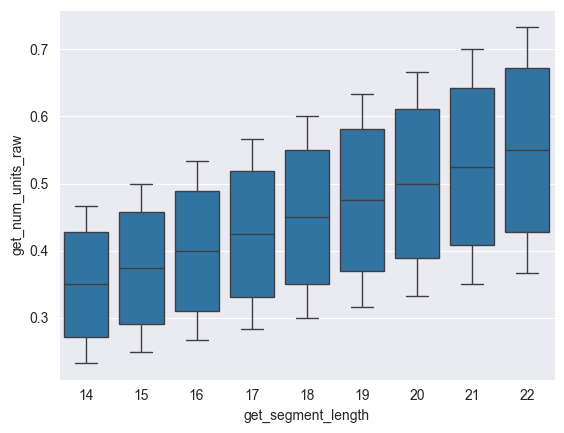

In [238]:
import seaborn as sns

sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw');

Lowest Profit:  -24.6
Highest Profit:  45.12
Mean Profit:  16.02
Mean Material Loss:  0.58
Median Profit:  18.5
Hourly Profit:  35.6
Mean Material Loss:  0.58


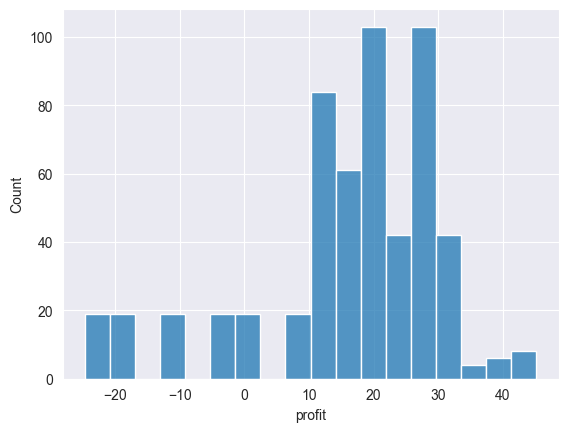

In [244]:
# Verifying that there is still a profit margin in the worst case scenarios.
df_price = df.copy()
COST_PER_UNIT = (15 / 2) + 8 #Two units per order plus shipping and handling
PROCESS_TIME_PER_ORDER = .45
COST_PER_COLOR = 5
df_price['price'] = 35 + df_price['num_colors'] * COST_PER_COLOR
df_price['num_units'] = df_build_stats['get_num_units_raw'].round(1) * df_build_stats['num_colors']
df_price['num_units_rounded'] = np.ceil(df_build_stats['get_num_units_raw'] * 4)/4 * df_build_stats['num_colors']
df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
df_price['material_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_price['material_cost']= df_price['num_units_rounded'] * COST_PER_UNIT
df_price['profit']= df_price['price'] - df_price['material_cost']
# Making copy of data for backup
df_price1 = df_price.copy()
meanProfit = df_price.profit.mean()
print("Lowest Profit: ",df_price.profit.min().round(1))
print("Highest Profit: ",df_price.profit.max().round(2))
print("Mean Profit: ",df_price.profit.mean().round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))
print("Median Profit: ",df_price.profit.median().round(2))
print("Hourly Profit: ", (df_price.profit.mean() / PROCESS_TIME_PER_ORDER).round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))
profit_columns = ['profit', 'material_loss', 'material_length', 'price', 'material_cost']
sns.histplot(x='profit', data=df_price);


#### Observations
- There is only a negative profit on one of the items in the chart it used some fairly unrealistic values.
- The mean profit for this data set is over 20.
- The mean material loss is around 0.50 units per order.
- This number assumes no waste material is recovered.


### Original Data Plots and Graphs

Creating derived field order_size which is calculated by adding the length, weight, and num_colors for each order.

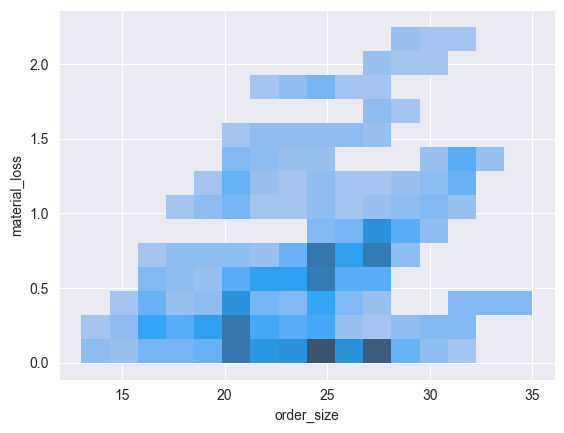

In [240]:
# Creating single metric for order size for future graphs
df_price['order_size'] = df_price['length'] + df_price['width'] + df_price['num_colors']
sns.histplot(data=df_price, x='order_size', y='material_loss');

### Limit Max value for Number of Colors

Lowest Profit:  -4.75
Max Profit:  41.75
Mean Profit:  22.0


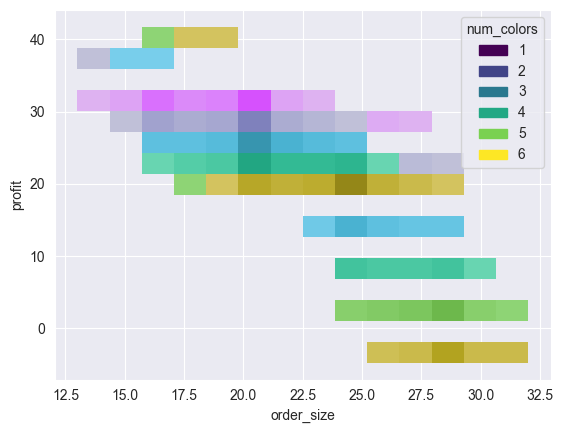

In [242]:
MAX_COLOR_NUM = 6
df_price2 = df_price[df_price['num_colors'] <= MAX_COLOR_NUM]
print("Lowest Profit: ", df_price2.profit.min().round(2))
print("Max Profit: ", df_price2.profit.max().round(2))
print("Mean Profit: ", df_price2.profit.mean().round(0))
sns.histplot(data=df_price2, x='order_size', y='profit', hue='num_colors', palette='viridis');

#### Conclusion
- If we limit the max color number to 6 there are still items in the dataset with a negative profit
- The mean profit for this chart is over $25
- Perhaps limiting the number of colors isn't idea.
#### Proposal
- Limit order size by material length instead


### Set Max Material Length

Removing all orders with material_length > 30 feet from the dataset
Lowest Profit:  15.12
Max Profit:  44.0
Mean Profit:  27.0


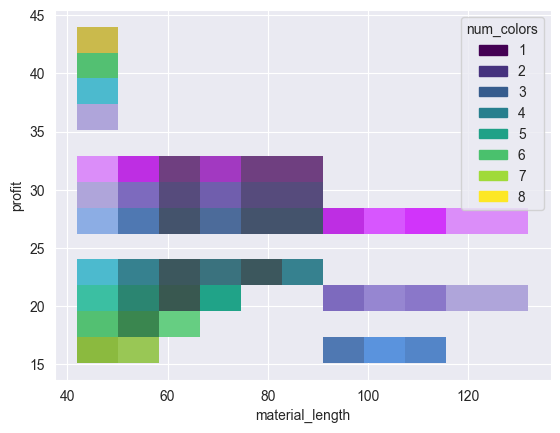

In [266]:
# Adding a max limit to order size
MAX_MATERIAL_LENGTH = 12 * 30
df_price3 = df_price.copy()
df_price3 = df_price[(df_price['material_length'] * df_price['num_colors']) < MAX_MATERIAL_LENGTH]
print(f"Removing all orders with material_length > 30 feet from the dataset")
print("Lowest Profit: ",df_price3.profit.min().round(2))
print("Max Profit: ",df_price3.profit.max().round(2))
print("Mean Profit: ",df_price3.profit.mean().round(0))

sns.histplot(data=df_price3, x='material_length', y='profit', hue='num_colors', palette='viridis');


#### Observations
- All orders that use less than 30 ft of material are profitable.
- Material length is a derived field so ideally the pricing should be based on length and width of the item.

### Suggestions
- Client should do one of the following things.
  - Limit their orders to orders that use less than 30 ft of materials.
  - Add an extra charge for orders that use more than 30 ft of materials.